# Comparison of MEFISTO and PRISMO on Visium Data from MEFISTO paper

In [45]:
%load_ext autoreload
%autoreload 2

import h5py
import matplotlib.pyplot as plt
import pandas as pd
from data_loader import load_mefisto_visium
from scipy.stats import pearsonr

# from mofapy2.run.entry_point import entry_point
from utils import match, plot_factors_covariate_2d

# from famo.core import CORE
from famo.utils_io import load_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
adata = load_mefisto_visium()

## MEFISTO

In [3]:
# ent = entry_point()
# ent.set_data_options(use_float32=True)
# ent.set_data_from_anndata(adata)
# ent.set_model_options(factors=4)
# ent.set_train_options()
# ent.set_train_options(seed=54321)
# n_inducing = 1000

# ent.set_covariates([adata.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
# ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing / adata.n_obs, start_opt=10, opt_freq=10)
# ent.build()
# ent.run()

# expectations = ent.model.getExpectations()
# ent.save("mefisto_model.hdf5")

mefisto_model = h5py.File("mefisto_model.hdf5", "r")

## PRISMO

In [4]:
# model = CORE(device="cuda:0")
# model.fit(
#     data=adata,
#     n_factors=4,
#     weight_prior="SnS",
#     factor_prior="GP",
#     likelihoods="Normal",
#     covariates_obsm_key="spatial",
#     max_epochs=3000,
#     early_stopper_patience=500,
#     lr=0.05,
#     plot_data_overview=False,
#     save=True,
#     save_path="prismo_model",
#     init_scale=0.1,
#     gp_n_inducing=1000,
#     seed=5432,
# )

prismo_model = load_model("prismo_model")

Model loaded from prismo_model/model.pkl
Parameters loaded from prismo_model/params.save


## Factor Matching

In [5]:
z_prismo = prismo_model.get_factors()['group_1'].T

z_mefisto = mefisto_model["expectations"]["Z"]["group1"][:]
samples_mefisto = mefisto_model["samples"]["group1"][:]
z_mefisto = pd.DataFrame(z_mefisto, index=[f"Factor {i+1}" for i in range(4)], columns=samples_mefisto)
z_mefisto.columns = [x.decode() for x in z_mefisto.columns]
z_mefisto = z_mefisto.sort_index(axis=1)

In [6]:
w_prismo = prismo_model.get_weights()['view_1']

w_mefisto = mefisto_model["expectations"]["W"]["rna"][:]
features_mefisto = mefisto_model["features"]["rna"][:]
w_mefisto = pd.DataFrame(w_mefisto, index=[f"Factor {i+1}" for i in range(4)], columns=features_mefisto)
w_mefisto.columns = [x.decode() for x in w_mefisto.columns]
w_mefisto = w_mefisto.sort_index(axis=1)

In [7]:
z_inds, z_signs = match(z_mefisto.values, z_prismo.values, dim=-2)

z_prismo = z_prismo.iloc[z_inds]
z_prismo = z_prismo * z_signs.reshape(-1, 1)

w_prismo = w_prismo.iloc[z_inds]
w_prismo = w_prismo * z_signs.reshape(-1, 1)

In [8]:
plot_factors_covariate_2d(z_prismo.values.T, adata.obsm["spatial"])

alt.HConcatChart(...)

In [9]:
plot_factors_covariate_2d(z_mefisto.values.T, adata.obsm["spatial"])

alt.HConcatChart(...)

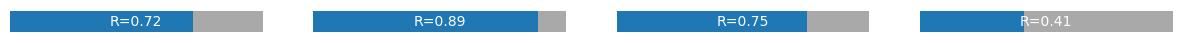

In [73]:
fig, axs = plt.subplots(1, 4, figsize=(15, 0.3))

for i in range(4):
    ax = axs.flatten()[i]
    ax.barh(0, 1, color="darkgray")
    value = pearsonr(z_prismo.iloc[i], z_mefisto.iloc[i])[0]
    ax.barh(0, value, color="C0")
    ax.text(0.5, 0, f'R={value:.2f}', va='center', ha='center', color='white')
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plt.show()

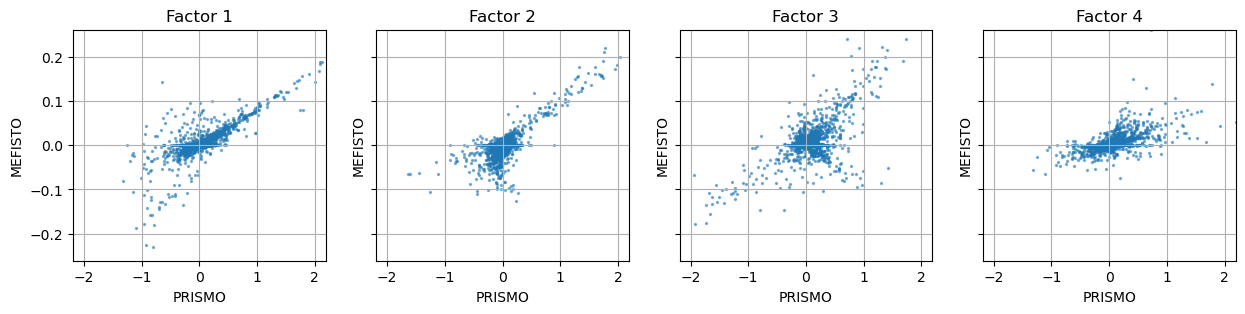

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    ax.scatter(w_prismo.iloc[i], w_mefisto.iloc[i], s=2, alpha=0.5)
    ax.set_title(f"Factor {i+1}")
    ax.grid()
    x_max = w_prismo.iloc[i].abs().max()
    ax.set_xlim(-x_max, x_max)
    y_max = w_mefisto.iloc[i].abs().max()
    ax.set_ylim(-y_max, y_max)
    ax.set_xlabel("PRISMO")
    ax.set_ylabel("MEFISTO")

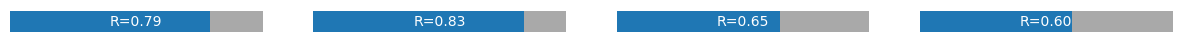

In [74]:
fig, axs = plt.subplots(1, 4, figsize=(15, 0.3))

for i in range(4):
    ax = axs.flatten()[i]
    ax.barh(0, 1, color="darkgray")
    value = pearsonr(w_prismo.iloc[i], w_mefisto.iloc[i])[0]
    ax.barh(0, value, color="C0")
    ax.text(0.5, 0, f'R={value:.2f}', va='center', ha='center', color='white')
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

plt.show()